# Initial Setup

In [ ]:
!pip install transformers datasets
!pip3 install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 9.2 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
userdata.get('huggingface')

# Loading and Processing Dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# loading dataset
from datasets import load_dataset
dataset = load_dataset("poem_sentiment")

Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})


In [ ]:
train_data = dataset['train']
test_data = dataset['test']
print(train_data[:5])

{'id': [0, 1, 2, 3, 4], 'verse_text': ['with pale blue berries. in these peaceful shades--', 'it flows so long as falls the rain,', 'and that is why, the lonesome day,', 'when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,', 'of inward strife for truth and liberty.'], 'label': [1, 2, 0, 3, 3]}


In [ ]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
print(df_train)
print(df_test)

      id                                         verse_text  label
0      0  with pale blue berries. in these peaceful shad...      1
1      1                it flows so long as falls the rain,      2
2      2                 and that is why, the lonesome day,      0
3      3  when i peruse the conquered fame of heroes, an...      3
4      4            of inward strife for truth and liberty.      3
..   ...                                                ...    ...
887  887  to his ears there came a murmur of far seas be...      2
888  888     the one good man in the world who knows me, --      1
889  889               faint voices lifted shrill with pain      0
890  890  an', fust you knowed on, back come charles the...      2
891  891     in the wild glens rough shepherds will deplore      0

[892 rows x 3 columns]
      id                                         verse_text  label
0      0                      my canoe to make more steady,      2
1      1  and be glad in the summer mo

In [ ]:
# checking for null values
null_train = df_train['label'].isnull().sum()
print("Number of null labels in train_df:", null_train)
null_test = df_test['label'].isnull().sum()
print("Number of null labels in test_df:", null_test)

Number of null labels in train_df: 0
Number of null labels in test_df: 0


sexyyyyyyyyy!!!! No NULL Values

In [ ]:
# Checking frequency of each label
df_train['label'].value_counts()

2    555
0    155
1    133
3     49
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

2    69
0    19
1    16
Name: label, dtype: int64

Okayy, we have 49 values with label 3 ie. 'mixed emotions'. Lets just remove them


Also:

0 - negative,

1 - positive,

2 - no_impact (neutral)

In [ ]:
df_train = df_train[df_train['label'] != 3]
df_train['label'].value_counts()

2    555
0    155
1    133
Name: label, dtype: int64

In [ ]:
# Marge both test and train datasets. we dont need any segregation for testing the models
df = pd.concat([df_test, df_train], ignore_index=True)

# Model Evaluation Setup

We will be using Accuracy, Precision, Recall and F1 Score to evaluate our model

In [ ]:
def evaluate_model(true_labels, predicted_labels):
  metrics = {
    "Accuracy": accuracy_score(true_labels, predicted_labels),
    "Precision": precision_score(true_labels, predicted_labels, average="weighted"),
    "Recall": recall_score(true_labels, predicted_labels, average="weighted"),
    "F1": f1_score(true_labels, predicted_labels, average="weighted")
  }
  return metrics


# Model 1
### finiteautomata / bertweet-base-sentiment-analysis

In [ ]:
# loading hugging face model using transformers pipeline
from transformers import pipeline

pipe1 = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

In [ ]:
for index, row in df.iterrows():
    text = row['verse_text']  # Extract the text for sentiment analysis

    # Get prediction using the model
    prediction = pipe1(text)[0]
    predicted_label = prediction['label']  # Extract the predicted label

    # Map the predicted label to dataset's labels
    mapped_label = {
        "POS": 1,  # Positive
        "NEG": 0,  # Negative
        "NEU": 2   # Neutral (no_impact)
    }[predicted_label]

    # Store the mapped label (optional)
    df.loc[index, 'prediction model 1'] = mapped_label  # Add a new column

In [ ]:
print(df[:5])

   id                                         verse_text  label  \
0   0                      my canoe to make more steady,      2   
1   1  and be glad in the summer morning when the kin...      1   
2   2       and when they reached the strait symplegades      2   
3   3                             she sought for flowers      2   
4   4                       if they are hungry, paradise      2   

   prediction model 1  prediction model 2  
0                 2.0                 2.0  
1                 1.0                 2.0  
2                 2.0                 2.0  
3                 2.0                 2.0  
4                 2.0                 2.0  


In [ ]:
# Evaluation the model
predicted_labels = df['prediction model 1']
true_labels = df['label']

metrics = evaluate_model(true_labels, predicted_labels)
print(metrics)

{'Accuracy': 0.7729672650475184, 'Precision': 0.7729707354099187, 'Recall': 0.7729672650475184, 'F1': 0.7560787699269057}


In [ ]:
results = pd.DataFrame([{"Model Name": "finiteautomata", **metrics}])
print(results)

       Model Name  Accuracy  Precision    Recall        F1
0  finiteautomata  0.772967   0.772971  0.772967  0.756079


# Model 2
### cardiffnlp / twitter-roberta-base-sentiment-latest

In [ ]:
# loading hugging face model using transformers pipeline
pipe2 = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(pipe2("You are best"))
print(pipe2("You are worst"))
print(pipe2("okay"))

[{'label': 'positive', 'score': 0.9437792301177979}]
[{'label': 'negative', 'score': 0.8927664756774902}]
[{'label': 'neutral', 'score': 0.5299233794212341}]


So this model has 3 labels as - positive, negative and neutraul 👍

In [ ]:
for index, row in df.iterrows():
    text = row['verse_text']  # Extract the text for sentiment analysis

    # Get prediction using the model
    prediction = pipe2(text)[0]
    predicted_label = prediction['label']  # Extract the predicted label

    # Map the predicted label to dataset's labels
    mapped_label = {
        "positive": 1,  # Positive
        "negative": 0,  # Negative
        "neutral": 2   # Neutral (no_impact)
    }[predicted_label]

    # Store the mapped label (optional)
    df.loc[index, 'prediction model 2'] = mapped_label  # Add a new column

In [ ]:
print(df[:5])

   id                                         verse_text  label  \
0   0                      my canoe to make more steady,      2   
1   1  and be glad in the summer morning when the kin...      1   
2   2       and when they reached the strait symplegades      2   
3   3                             she sought for flowers      2   
4   4                       if they are hungry, paradise      2   

   prediction model 1  prediction model 2  
0                 2.0                 2.0  
1                 1.0                 1.0  
2                 2.0                 2.0  
3                 2.0                 2.0  
4                 2.0                 2.0  


In [ ]:
# Evaluation the model
predicted_labels_2 = df['prediction model 2']
true_labels_2 = df['label']

metrics_2 = evaluate_model(true_labels_2, predicted_labels_2)
print(metrics_2)

{'Accuracy': 0.8025343189017952, 'Precision': 0.7982847277594599, 'Recall': 0.8025343189017952, 'F1': 0.7978141093695055}


In [ ]:
results = pd.concat([results, pd.DataFrame([{"Model Name": "cardiffnlp", **metrics_2}])], ignore_index=True)
print(results)

       Model Name  Accuracy  Precision    Recall        F1
0  finiteautomata  0.772967   0.772971  0.772967  0.756079
1      cardiffnlp  0.802534   0.798285  0.802534  0.797814


# Model 3
### ProsusAI / finbert

In [ ]:
pipe3 = pipeline("text-classification", model="ProsusAI/finbert")

In [ ]:
for index, row in df.iterrows():
    text = row['verse_text']  # Extract the text for sentiment analysis

    # Get prediction using the model
    prediction = pipe3(text)[0]
    predicted_label = prediction['label']  # Extract the predicted label

    # Map the predicted label to dataset's labels
    mapped_label = {
        "positive": 1,  # Positive
        "negative": 0,  # Negative
        "neutral": 2   # Neutral (no_impact)
    }[predicted_label]

    # Store the mapped label (optional)
    df.loc[index, 'prediction model 3'] = mapped_label  # Add a new column

In [ ]:
print(df[:5])

   id                                         verse_text  label  \
0   0                      my canoe to make more steady,      2   
1   1  and be glad in the summer morning when the kin...      1   
2   2       and when they reached the strait symplegades      2   
3   3                             she sought for flowers      2   
4   4                       if they are hungry, paradise      2   

   prediction model 1  prediction model 2  prediction model 3  
0                 2.0                 2.0                 2.0  
1                 1.0                 1.0                 2.0  
2                 2.0                 2.0                 2.0  
3                 2.0                 2.0                 2.0  
4                 2.0                 2.0                 2.0  


In [ ]:
# Evaluation the model
predicted_labels_3 = df['prediction model 3']
true_labels_3 = df['label']

metrics_3 = evaluate_model(true_labels_3, predicted_labels_3)
print(metrics_3)

{'Accuracy': 0.6863780359028511, 'Precision': 0.6418804749367968, 'Recall': 0.6863780359028511, 'F1': 0.6022768671997251}


In [ ]:
results = pd.concat([results, pd.DataFrame([{"Model Name": "ProsusAI", **metrics_3}])], ignore_index=True)
print(results)

       Model Name  Accuracy  Precision    Recall        F1
0  finiteautomata  0.772967   0.772971  0.772967  0.756079
1      cardiffnlp  0.802534   0.798285  0.802534  0.797814
2        ProsusAI  0.686378   0.641880  0.686378  0.602277


# Visualization


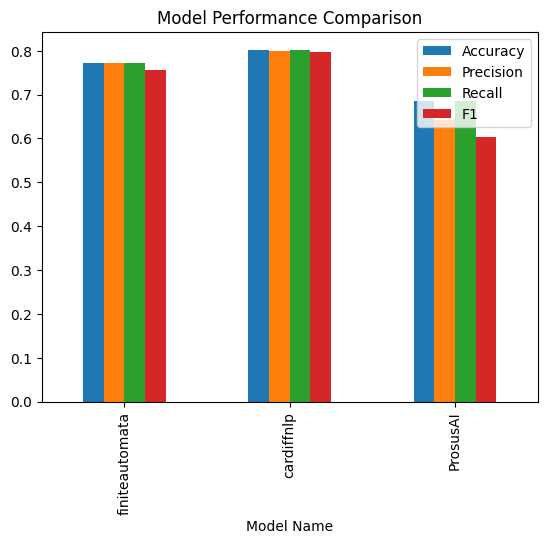

In [ ]:
results.plot(x='Model Name', y=['Accuracy', 'Precision', 'Recall', 'F1'], kind='bar')
plt.title('Model Performance Comparison')
plt.show()


# Topsis Analysis

In [ ]:
results.to_csv("results.csv", index=False)

In [ ]:
!pip install --index-url https://test.pypi.org/simple/ hp-toposis

>Topsis baad me kiya jaega - hp